In [34]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [35]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter

from sklearn.model_selection import train_test_split

In [37]:
df = pd.read_csv('Train.csv')

In [27]:
df.columns

Index(['application_id_current', 'target', 'prev_loan_cnt', 'amt_application',
       'credit_cnt', 'sum_of_days_credit', 'credit_day_overdue',
       'cnt_credit_prolong', 'prev_app_cnt', 'amt_instalment', 'amt_payment',
       'num_instalment_number', 'appliation_w_non_payment', 'aave_cnt'],
      dtype='object')

In [ ]:
# sns.pairplot(df.drop(['application_id_current'], axis=1), diag_kind='hist')

In [ ]:
sns.pairplot(df.drop(['application_id_current'], axis=1), diag_kind='hist', hue='target')

In [ ]:
import plotly.figure_factory as ff

In [ ]:
# fig = ff.create_scatterplotmatrix(
#     df,
#     diag='box', # scatter, histogram, box
#     index='target'
# )

In [ ]:
# fig.show()

# Modelling

In [38]:
def cross_valid_roc(X, y, classfier, folds=8):
    from numpy import interp
    from sklearn import svm, datasets
    from sklearn.metrics import roc_curve, auc
    from sklearn.model_selection import StratifiedKFold

    # Run classifier with cross-validation and plot ROC curves
    skf = StratifiedKFold(n_splits=folds)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        probas_ = classfier.fit(X[train_idx], y[train_idx]).predict_proba(X[test_idx])
        fpr, tpr, thresholds = roc_curve(y[test_idx], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    #end

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= skf.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    
    return classfier

# Features Selection by VIF

In [39]:
features = [col for col in df.columns if ('application_id_current' not in col) and ('target') not in col]
X, y = df[features].values, df['target'].values

In [7]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = features
 
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(len(features))]
  
print(vif_data)

                     feature        VIF
0   prev_loan_cnt             8.100848 
1   amt_application           3.848105 
2   credit_cnt                10.676846
3   sum_of_days_credit        9.770361 
4   credit_day_overdue        1.005030 
5   cnt_credit_prolong        1.042286 
6   prev_app_cnt              10.611088
7   amt_instalment            50.535995
8   amt_payment               45.255354
9   num_instalment_number     11.080711
10  appliation_w_non_payment  1.000069 
11  aave_cnt                  3.394672 


# Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
rf_clf = RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=8,
    min_samples_split=30,
    min_samples_leaf=30,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

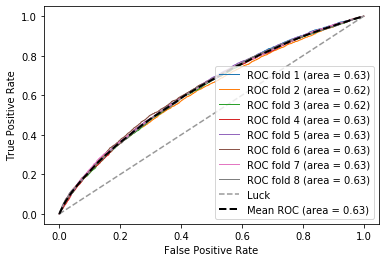

In [42]:
trained_model = cross_valid_roc(X, y, rf_clf, folds=8)

# Logistic Regression

In [13]:
features = [col for col in df.columns if ('application_id_current' not in col) and ('target') not in col]
features.remove('amt_instalment')
features.remove('credit_cnt')
X, y = df[features].values, df['target'].values

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [15]:
logistic_rgr_clf = LogisticRegression(
    penalty='l2',
    C=0.9,
    solver='lbfgs'
)

In [16]:
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

/Users/dev/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=0.9)

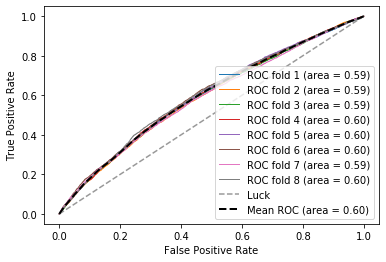

In [17]:
cross_valid_roc(scaled_X, y, logistic_rgr_clf, folds=8)

# Undersampling

In [18]:
from imblearn.under_sampling import RandomUnderSampler

In [19]:
rus = RandomUnderSampler(sampling_strategy=0.5)
X_res, y_res = rus.fit_resample(X, y)

In [20]:
X_res.shape, y_res.shape

((74475, 10), (74475,))

In [21]:
Counter(y_res)

Counter({0.0: 49650, 1.0: 24825})

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, min_samples_leaf=30, min_samples_split=30,
                       n_estimators=500, n_jobs=-1, random_state=0)

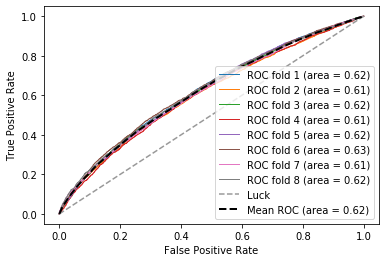

In [22]:
cross_valid_roc(X_res, y_res, rf_clf, folds=8)

# Neural Net

In [ ]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
EPOCHS = 32
BATCH_SIZE = 256
LEARNING_RATE = 0.001
THRESHOLD = 0.52

In [ ]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(np.array(y).reshape(-1, 1), dtype=torch.float32)
        self.length = self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return self.length

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_shape, input_shape * 2)
        self.fc2 = nn.Linear(input_shape * 2, input_shape * 2)
        self.fc3 = nn.Linear(input_shape * 2, input_shape * 2)
        self.fc4 = nn.Linear(input_shape * 2, input_shape)
        self.fc5 = nn.Linear(input_shape, 1)

    def forward(self, X):
        Z1 = torch.relu(self.fc1(X))
        Z2 = torch.relu(self.fc2(Z1))
        Z3 = torch.relu(self.fc3(Z2))
        Z4 = torch.relu(self.fc4(Z3))
        return torch.sigmoid(self.fc5(Z4))

In [ ]:
def evaluate_binary_classification(pred, true):
    P = pred[np.where(true == 1)]
    N = pred[np.where(true == 0)]
    
    TP = np.sum(P == 1)
    FN = np.sum(P == 0)
 
    FP = np.sum(N == 1)
    TN = np.sum(N == 0)
    
    return TP, FP, TN, FN

In [ ]:
def train_loop(dataloader, model, loss_ftn, optimizer):
    size = len(dataloader.dataset)
    train_loss = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_ftn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * len(X)
        train_loss.append(loss)
        if batch % BATCH_SIZE == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    # VISUALIZE
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(train_loss)
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    plt.tight_layout()
    plt.show()

In [ ]:
def test_loop(dataloader, model, loss_ftn):
    size = len(dataloader.dataset)
    test_loss = 0
    TP, FP, TN, FN = 0, 0, 0, 0
    
    y_pred = np.array([])
    y_true = np.array([])
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)

            # Convert into numpy
            pred_np = pred.detach().numpy()
            y_np = y.detach().numpy()
            
            # Classify into binary groups
            pred_np[pred_np >= THRESHOLD] = 1
            pred_np[pred_np < THRESHOLD] = 0
            
            # Calculate P, N
            _TP, _FP, _TN, _FN = evaluate_binary_classification(pred=pred_np, true=y_np)
            TP += _TP
            FP += _FP
            TN += _TN
            FN += _FN
            
            # Append
            y_pred = np.append(y_pred, pred_np)
            y_true = np.append(y_true, y_np)
    
    """
    EVALUATE METRICS
    """
    print("Precision is a ratio of TP, out of predicted positives")
    print("Recall is a ratio of TP, out of actual positives\n")
    print(classification_report(y_pred=y_pred, y_true=y_true))
    print(f"0: PRECISION: {np.round(TN / (TN + FN), 2)}, RECALL: {np.round(TN / (TN + FP), 2)}\n")
    print(f"1: PRECISION: {np.round(TP / (TP + FP), 2)}, RECALL: {np.round(TP / (TP + FN), 2)}\n")

#     print(confusion_matrix(y_pred=pred_np, y_true=y_np))
#     print(classification_report(y_pred=y_pred, y_true=y_true))

In [ ]:
X_res, y_res = rus.fit_resample(scaled_X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.4, stratify=y_res, random_state=10)

In [ ]:
# Organize PyTorch DataSet
train_set = dataset(X_train, y_train)
test_set = dataset(X_test, y_test)

# Transform into DataLoader
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [ ]:
# Initialize the model        
model = NeuralNetwork(input_shape=scaled_X.shape[1])

# Define loss criterion
loss_ftn = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_ftn, optimizer)
    test_loop(test_dataloader, model, loss_ftn)
print("Done!")

# Predict with the best model

In [45]:
test_df = pd.read_csv("Test.csv")

In [46]:
test_df.head()

,application_id_current,target,prev_loan_cnt,amt_application,credit_cnt,sum_of_days_credit,credit_day_overdue,cnt_credit_prolong,prev_app_cnt,amt_instalment,amt_payment,num_instalment_number,appliation_w_non_payment,aave_cnt
0,100001,0.0,1.0,24835.5,7.0,-5145.0,0.0,0.0,2.0,41195.925,41195.925,7.0,0.0,0.0
1,100005,0.0,2.0,44617.5,3.0,-572.0,0.0,0.0,1.0,56161.845,56161.845,9.0,0.0,0.0
2,100013,0.0,4.0,523485.0,4.0,-6950.0,0.0,0.0,4.0,1689174.270,1509736.545,155.0,3.0,96.0
3,100028,0.0,5.0,246037.5,12.0,-16821.0,0.0,0.0,3.0,562658.895,492310.665,113.0,1.0,49.0
4,100038,0.0,2.0,535455.0,0.0,0.0,0.0,0.0,1.0,133204.050,133204.050,12.0,0.0,0.0


In [48]:
predicted_y = trained_model.predict_proba(test_df[features].values)

In [50]:
test_df['target'] = predicted_y[:, 1]

In [52]:
test_df[['application_id_current', 'target']].to_csv('Result.csv')

In [ ]:
import sys
print(sys.executable) 

# Reference

* https://aave.com/
* http://blog.romanofoti.com/exploratory_classification_analysis/
* https://www.researchgate.net/publication/241634919_Credit_Evaluation_Model_of_Loan_Proposals_for_Indian_Banks

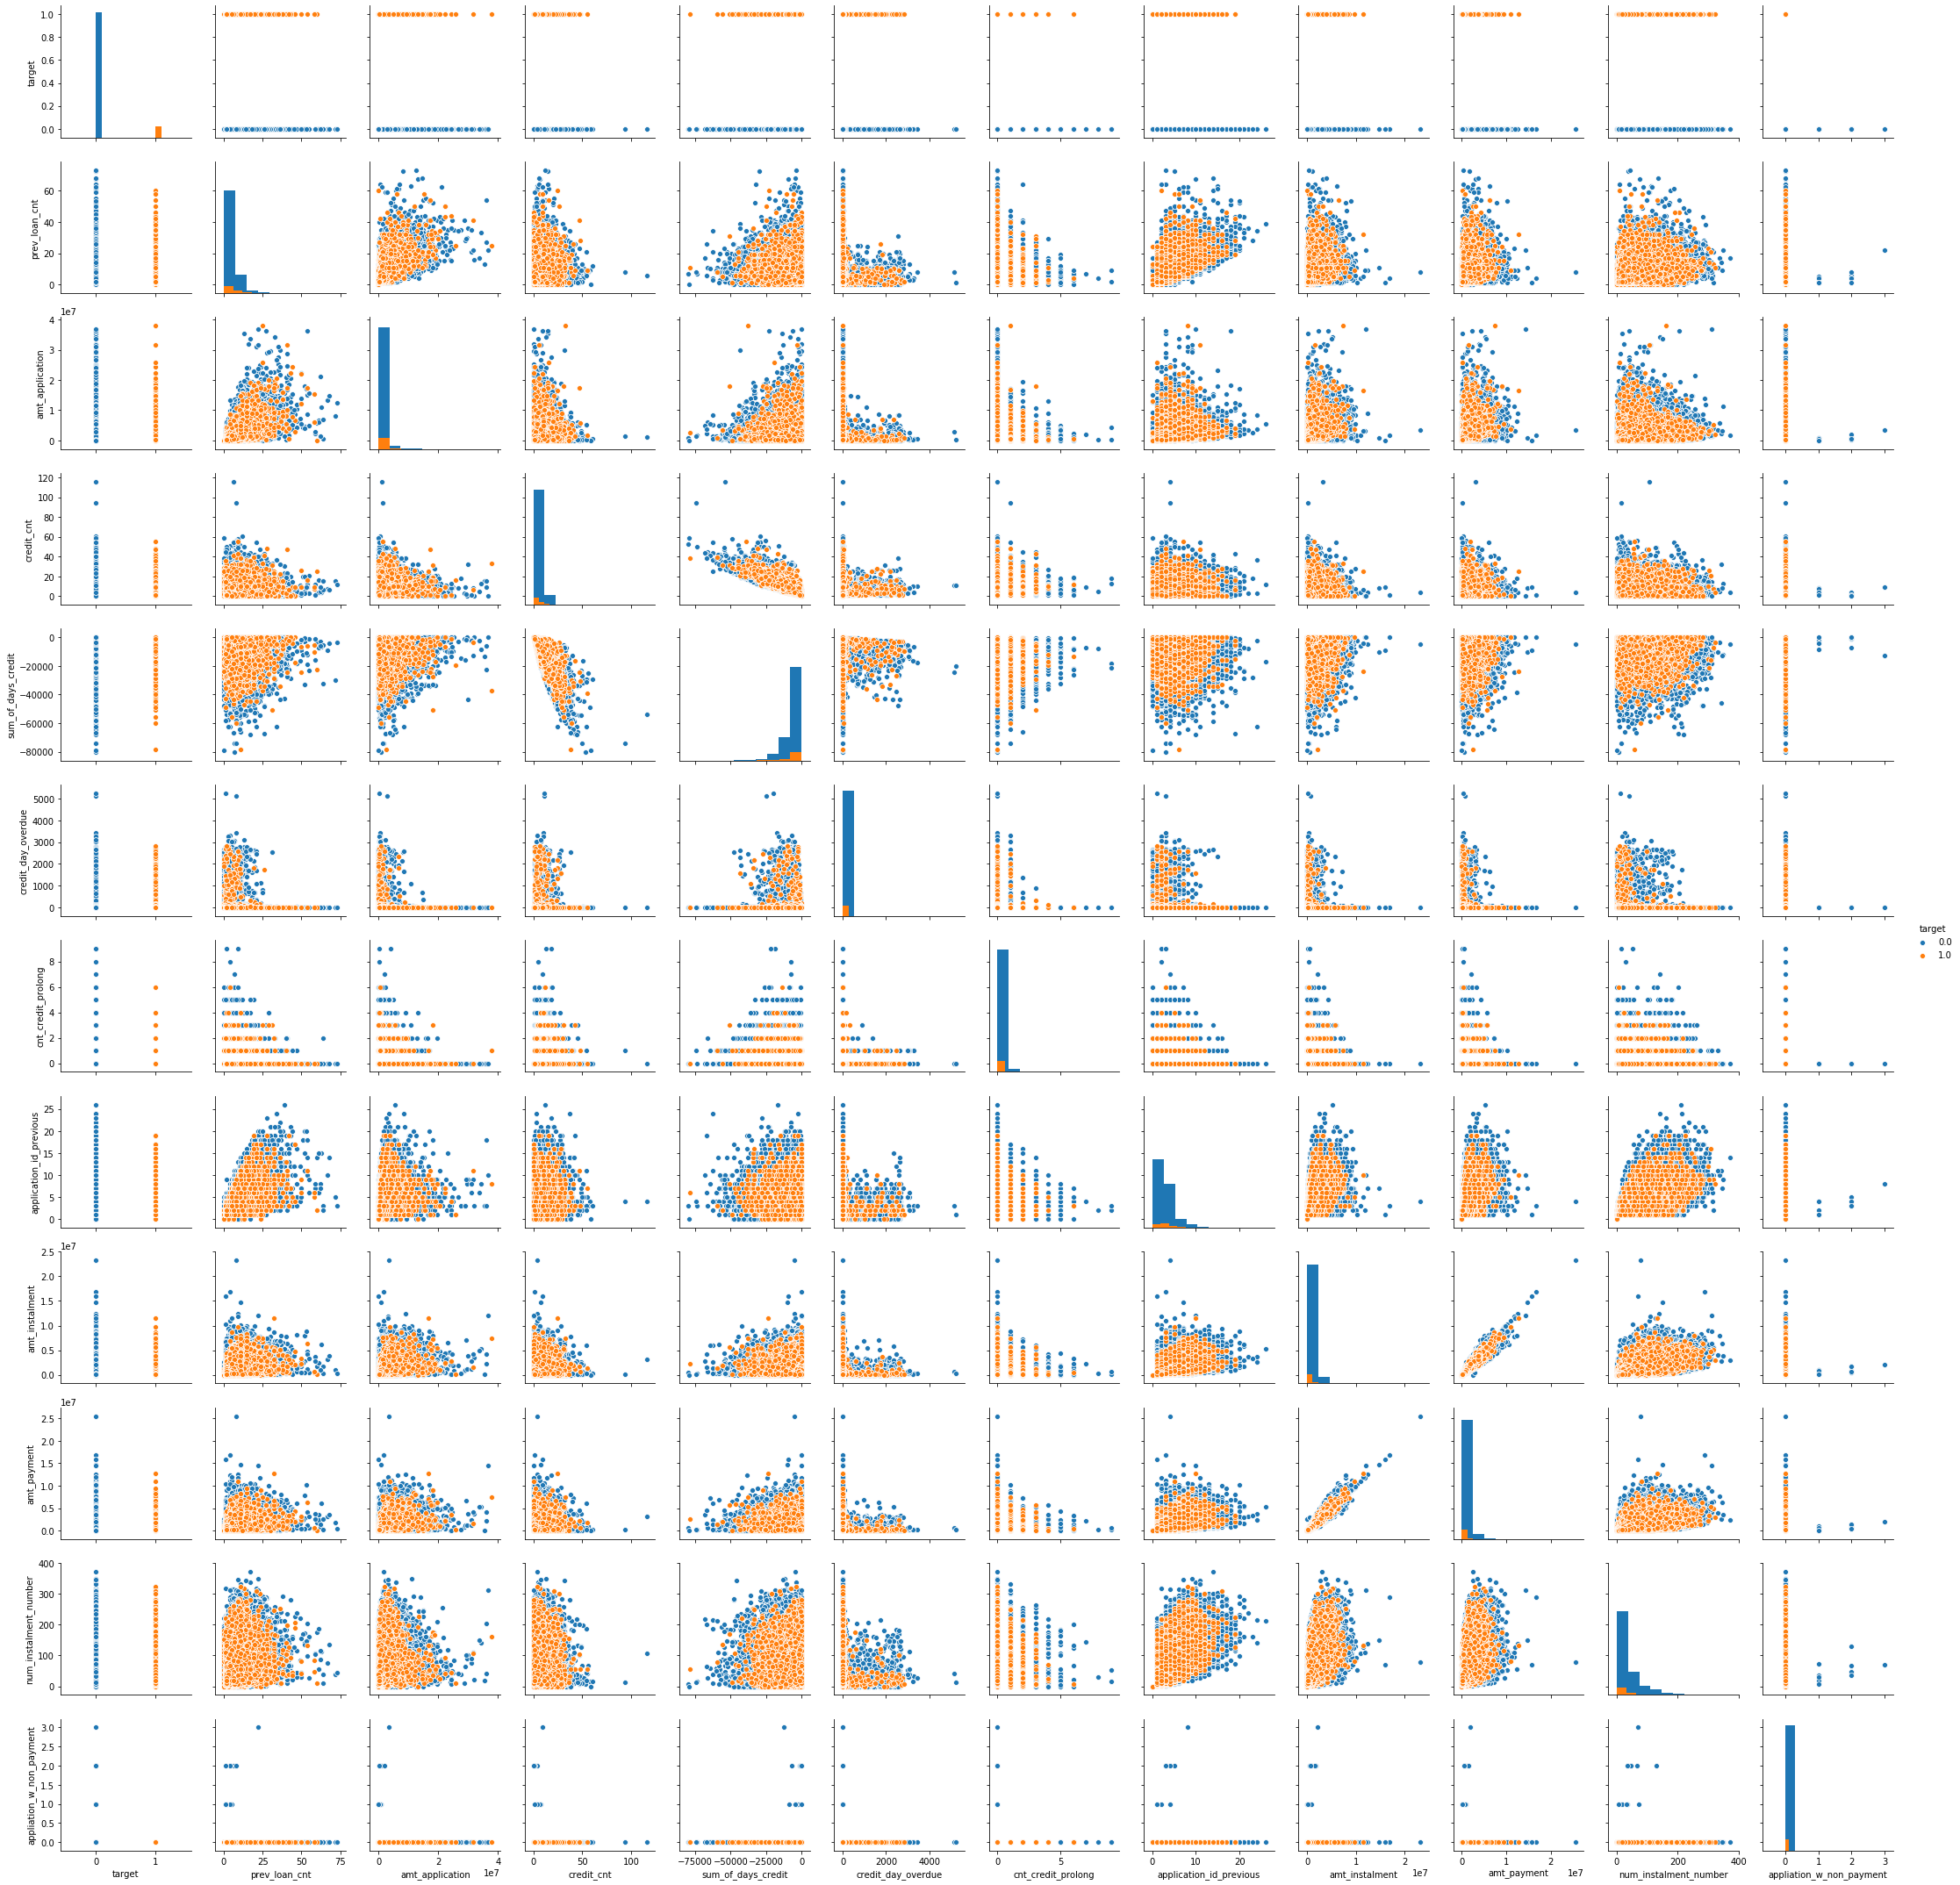